In [5]:
import pandas as pd
import numpy as np

# -----------------------------
# STEP 2: DATA AUDIT / QUALITY CHECKS
# -----------------------------

# 1) Load data
df = pd.read_csv("concrete_data.csv")

# 2) Quick overview
print("Dataset shape (rows, cols):", df.shape)
print("\nColumns:\n", df.columns.tolist())

print("\nFirst 5 rows:")
print(df.head())

# 3) Data types + missing values overview
print("\nData types:")
print(df.dtypes)

print("\nMissing values per column:")
print(df.isna().sum())

# 4) Basic descriptive statistics (helps spot weird values quickly)
print("\nSummary stats:")
print(df.describe().T)

# 5) Duplicate rows check
dup_count = df.duplicated().sum()
print(f"\nDuplicate rows: {dup_count}")
# If you want to remove duplicates later, do it carefully:
# df = df.drop_duplicates()

# 6) Sanity checks for impossible values (negative materials, negative age, etc.)
# (Concrete ingredients and age should not be negative.)
numeric_cols = df.columns  # all are numeric in this dataset usually
negatives = (df[numeric_cols] < 0).sum()

print("\nCount of negative values per column (should be 0):")
print(negatives[negatives > 0] if (negatives > 0).any() else "No negative values found.")

# 7) Optional: check zeros in places where zeros might be suspicious
# Note: Some columns CAN be zero (slag, fly_ash, superplasticizer), so don’t treat zero as error blindly.
zero_counts = (df == 0).sum()
print("\nZero counts per column:")
print(zero_counts)

# 8) Simple outlier scan using IQR rule (flagging only; do NOT remove automatically)
# This just tells you where extreme values might exist.
outlier_report = {}

for col in df.columns:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr

    outliers = ((df[col] < lower) | (df[col] > upper)).sum()
    outlier_report[col] = outliers

outlier_report = pd.Series(outlier_report).sort_values(ascending=False)
print("\nPotential outliers per column (IQR rule):")
print(outlier_report)

# 9) Target column check (make sure the target exists and looks reasonable)
target_col = "concrete_compressive_strength"
print("\nTarget column stats:")
print(df[target_col].describe())

# If target has any missing values, that is a big issue:
print("\nMissing values in target:", df[target_col].isna().sum())


Dataset shape (rows, cols): (1030, 9)

Columns:
 ['cement', 'blast_furnace_slag', 'fly_ash', 'water', 'superplasticizer', 'coarse_aggregate', 'fine_aggregate ', 'age', 'concrete_compressive_strength']

First 5 rows:
   cement  blast_furnace_slag  fly_ash  water  superplasticizer  \
0   540.0                 0.0      0.0  162.0               2.5   
1   540.0                 0.0      0.0  162.0               2.5   
2   332.5               142.5      0.0  228.0               0.0   
3   332.5               142.5      0.0  228.0               0.0   
4   198.6               132.4      0.0  192.0               0.0   

   coarse_aggregate  fine_aggregate   age  concrete_compressive_strength  
0            1040.0            676.0   28                          79.99  
1            1055.0            676.0   28                          61.89  
2             932.0            594.0  270                          40.27  
3             932.0            594.0  365                          41.05  
4     

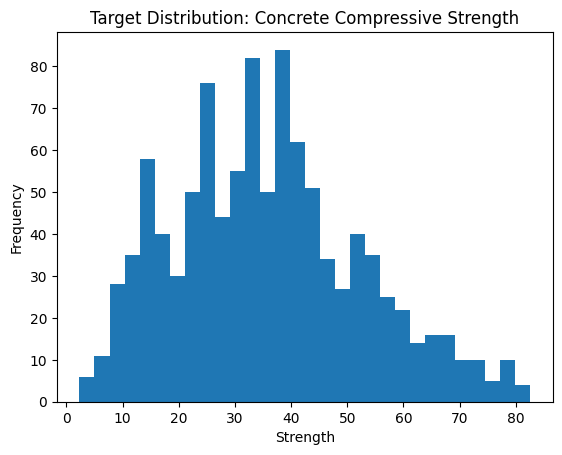

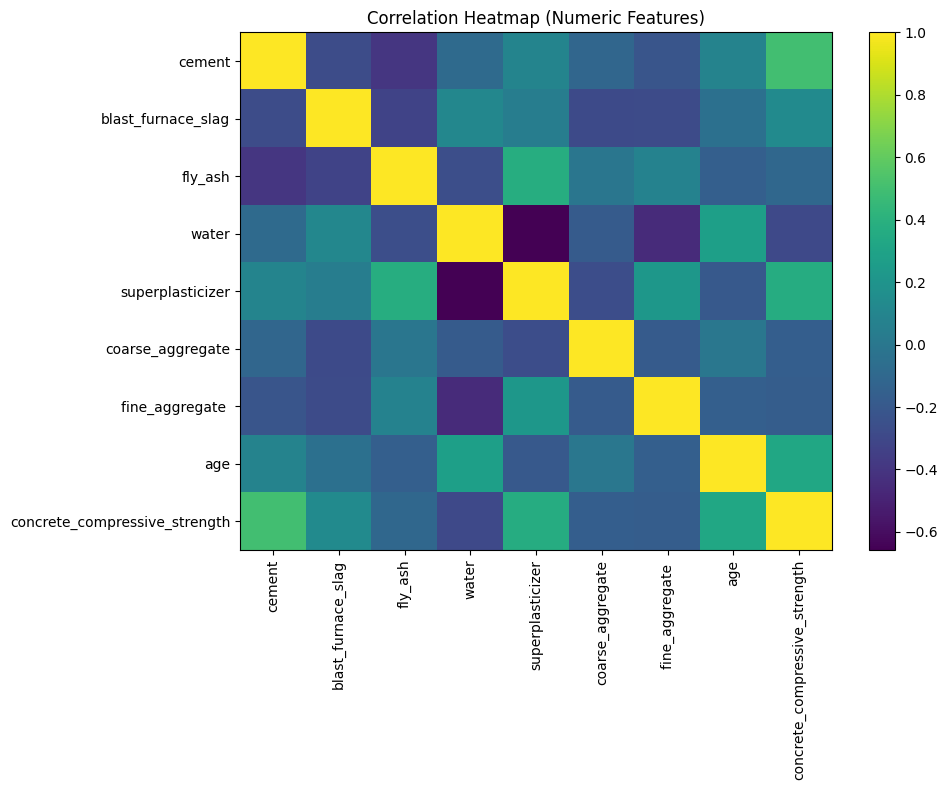


Correlation with target (sorted):
concrete_compressive_strength    1.000000
cement                           0.497832
superplasticizer                 0.366079
age                              0.328873
blast_furnace_slag               0.134829
fly_ash                         -0.105755
coarse_aggregate                -0.164935
fine_aggregate                  -0.167241
water                           -0.289633
Name: concrete_compressive_strength, dtype: float64


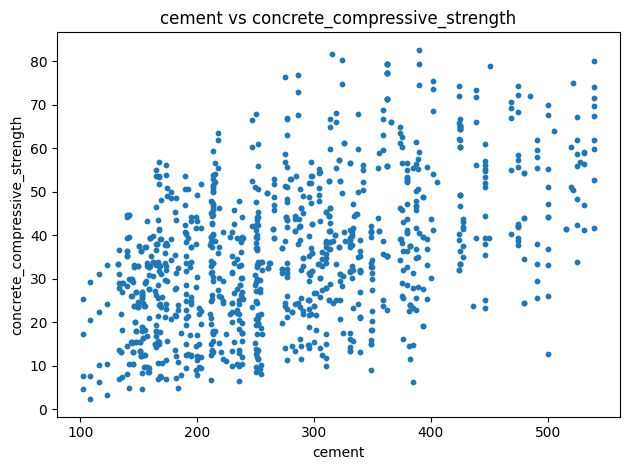

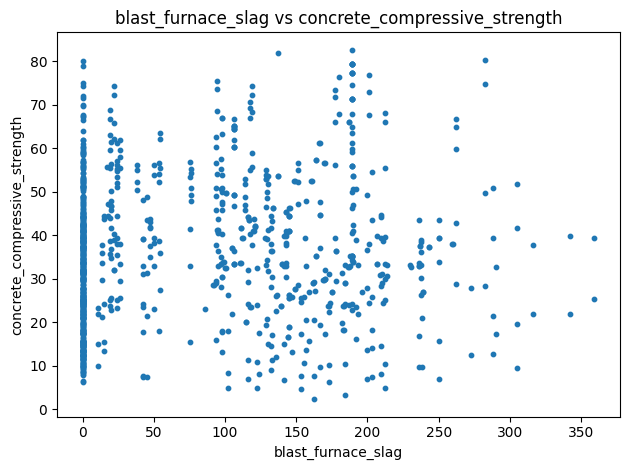

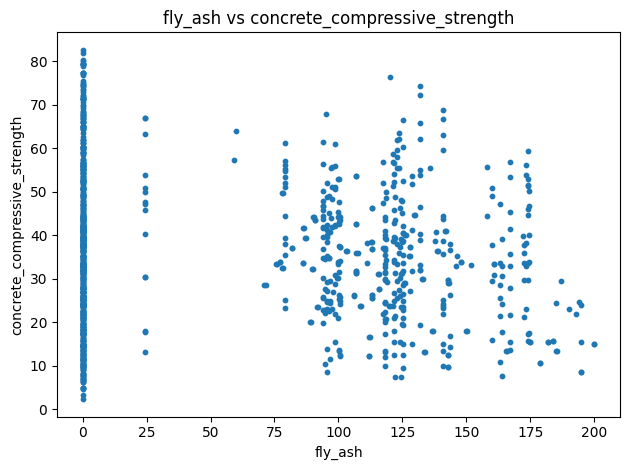

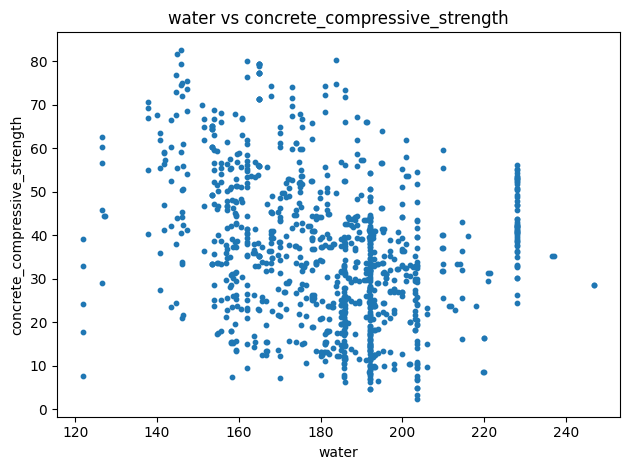

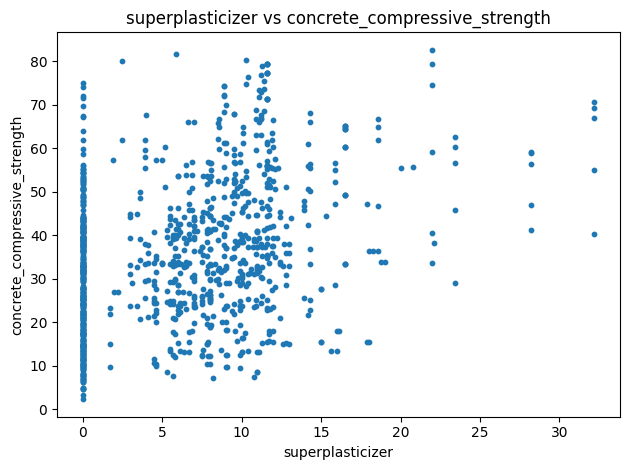

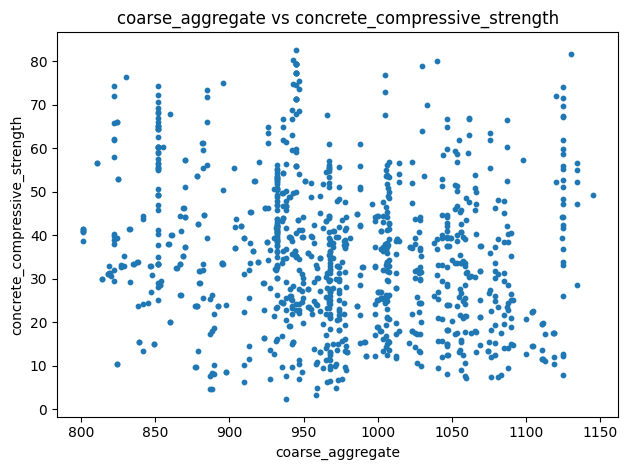

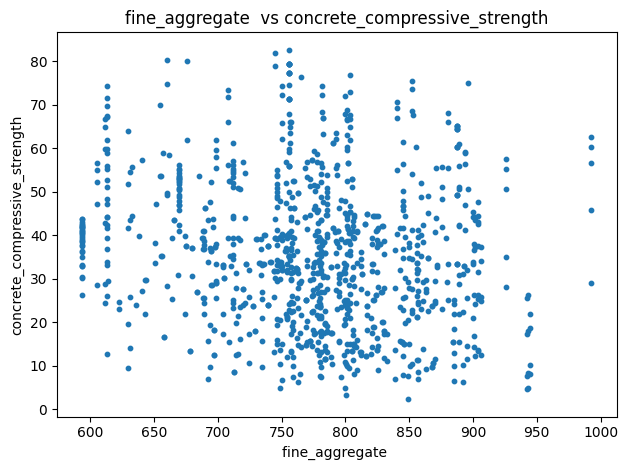

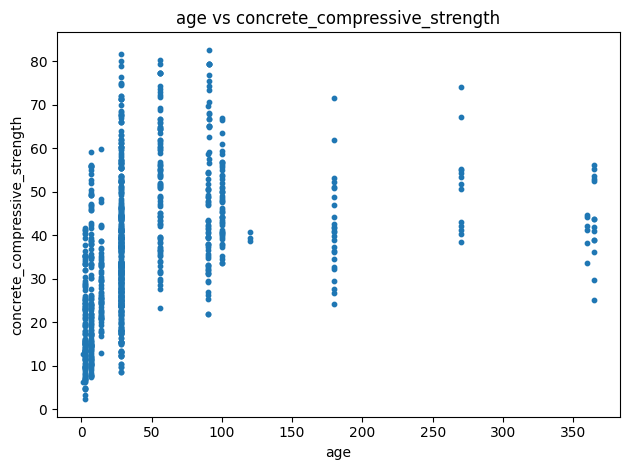

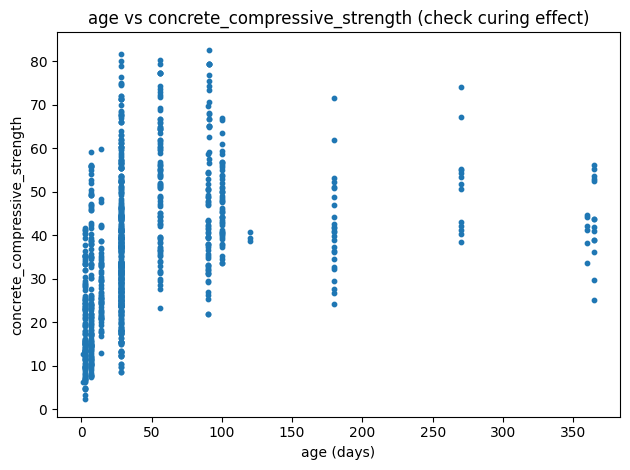

In [6]:
import matplotlib.pyplot as plt

# -----------------------------
# STEP 3: EDA (Exploratory Data Analysis)
# -----------------------------

target_col = "concrete_compressive_strength"
feature_cols = [c for c in df.columns if c != target_col]

# 1) Target distribution (important for regression)
plt.figure()
plt.hist(df[target_col], bins=30)
plt.title("Target Distribution: Concrete Compressive Strength")
plt.xlabel("Strength")
plt.ylabel("Frequency")
plt.show()

# 2) Correlation matrix (quick signal: what relates to strength?)
corr = df.corr(numeric_only=True)

plt.figure(figsize=(10, 8))
plt.imshow(corr, aspect="auto")
plt.colorbar()
plt.title("Correlation Heatmap (Numeric Features)")

# Put axis labels (so it’s readable)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.tight_layout()
plt.show()

# 3) Correlation with target (sorted)
target_corr = corr[target_col].sort_values(ascending=False)
print("\nCorrelation with target (sorted):")
print(target_corr)

# 4) Feature vs Target scatter plots (helps you see non-linear patterns)
# If you notice curves, that suggests tree-based models / boosting / feature engineering can help.
for col in feature_cols:
    plt.figure()
    plt.scatter(df[col], df[target_col], s=10)  # small dots so plot isn't messy
    plt.title(f"{col} vs {target_col}")
    plt.xlabel(col)
    plt.ylabel(target_col)
    plt.tight_layout()
    plt.show()

# 5) (Optional but very useful) Check "age" effect more closely
# Many concrete datasets show strength increases with age but not linearly.
plt.figure()
plt.scatter(df["age"], df[target_col], s=10)
plt.title("age vs concrete_compressive_strength (check curing effect)")
plt.xlabel("age (days)")
plt.ylabel("concrete_compressive_strength")
plt.tight_layout()
plt.show()


In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# -----------------------------
# DATA PROCESSING FOR CONCRETE DATASET
# (split by "age" + feature engineering + scaling)
# -----------------------------

# 1) Load data
df = pd.read_csv("concrete_data.csv")

# --- FIX: Strip whitespace from column names to handle 'fine_aggregate ' --- #
df.columns = df.columns.str.strip()
# ------------------------------------------------------------------------- #

# 2) Basic cleanup: remove exact duplicates (optional but often helpful)
#    If duplicates are meaningful to you, you can skip this.
df = df.drop_duplicates().reset_index(drop=True)

# 3) Define target and feature columns
target_col = "concrete_compressive_strength"

# 4) Sort by "age" to follow your "time-like" rule
#    (Oldest 80% train, next 10% val, most recent 10% test)
df = df.sort_values("age").reset_index(drop=True)

# 5) Feature engineering (high-impact for concrete strength)
#    These are common domain-inspired features.
#    IMPORTANT: This is safe because it only uses input columns (no target leakage).

# Total binder (cementitious material)
df["binder"] = df["cement"] + df["blast_furnace_slag"] + df["fly_ash"]

# Water-to-binder ratio (very important in concrete strength)
# Avoid divide-by-zero by replacing 0 binder with a tiny value
eps = 1e-8
df["water_binder_ratio"] = df["water"] / (df["binder"] + eps)

# Total aggregate and ratio
df["total_aggregate"] = df["coarse_aggregate"] + df["fine_aggregate"]
df["fine_coarse_ratio"] = df["fine_aggregate"] / (df["coarse_aggregate"] + eps)

# Binder composition fractions (how much slag/flyash in binder)
df["slag_frac"] = df["blast_furnace_slag"] / (df["binder"] + eps)
df["flyash_frac"] = df["fly_ash"] / (df["binder"] + eps)
df["cement_frac"] = df["cement"] / (df["binder"] + eps)

# Age transforms (captures non-linear curing effect)
df["log_age"] = np.log1p(df["age"])        # log(1+age)
df["sqrt_age"] = np.sqrt(df["age"])        # sqrt(age)

# 6) Separate features (X) and target (y)
y = df[target_col].copy()

# Drop target from X
X = df.drop(columns=[target_col])

# 7) Train/Val/Test split based on sorted order
n = len(df)
train_end = int(n * 0.80)
val_end = int(n * 0.90)

X_train = X.iloc[:train_end].copy()
y_train = y.iloc[:train_end].copy()

X_val = X.iloc[train_end:val_end].copy()
y_val = y.iloc[train_end:val_end].copy()

X_test = X.iloc[val_end:].copy()
y_test = y.iloc[val_end:].copy()

print("Split sizes:")
print("Train:", X_train.shape, y_train.shape)
print("Val:  ", X_val.shape, y_val.shape)
print("Test: ", X_test.shape, y_test.shape)

# 8) Scaling (IMPORTANT: fit scaler only on TRAIN to avoid leakage)
#    - Tree models (RF, GB, XGBoost) do not require scaling.
#    - Neural nets and linear models usually benefit from scaling.
scaler = StandardScaler()

# Fit on train only
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)

# Transform val and test using the SAME scaler
X_val_scaled = pd.DataFrame(
    scaler.transform(X_val),
    columns=X_val.columns,
    index=X_val.index
)

X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

print("\nReady outputs:")
print("- Raw:   X_train, X_val, X_test (best for tree models)")
print("- Scaled: X_train_scaled, X_val_scaled, X_test_scaled (best for DL/linear)")


Split sizes:
Train: (804, 17) (804,)
Val:   (100, 17) (100,)
Test:  (101, 17) (101,)

Ready outputs:
- Raw:   X_train, X_val, X_test (best for tree models)
- Scaled: X_train_scaled, X_val_scaled, X_test_scaled (best for DL/linear)


In [8]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# -----------------------------
# 1) Helper function to evaluate a regression model
# -----------------------------
def evaluate_regression(y_true, y_pred, label=""):
    """
    Prints common regression metrics:
    - MAE  : average absolute error
    - RMSE : penalizes large errors more
    - R2   : how much variance is explained (1.0 is best)
    """
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    print(f"\n[{label}]")
    print(f"MAE : {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R2  : {r2:.4f}")
    return mae, rmse, r2


# -----------------------------
# 2) Build a Random Forest model (good baseline for tabular regression)
# -----------------------------
# Notes about key parameters:
# - n_estimators: number of trees (more trees = usually better, but slower)
# - max_depth: limits depth (controls overfitting)
# - min_samples_leaf: prevents trees from becoming too specific
# - random_state: ensures reproducible results
rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=None,            # allow full depth (we will check validation performance)
    min_samples_leaf=1,
    min_samples_split=2,
    random_state=42,
    n_jobs=-1                  # use all CPU cores to speed up training
)

# -----------------------------
# 3) Train the model on TRAIN set only
# -----------------------------
rf.fit(X_train, y_train)

# -----------------------------
# 4) Evaluate on TRAIN and VALIDATION
#    (Validation score tells you how well it generalizes)
# -----------------------------
train_pred = rf.predict(X_train)
val_pred   = rf.predict(X_val)

evaluate_regression(y_train, train_pred, label="TRAIN")
evaluate_regression(y_val, val_pred, label="VALIDATION")

# -----------------------------
# 5) Optional: check feature importance (helps interpretation)
# -----------------------------
# This tells you which inputs the model used most.
importances = rf.feature_importances_
feat_imp = sorted(zip(X_train.columns, importances), key=lambda x: x[1], reverse=True)

print("\nTop 10 important features:")
for name, score in feat_imp[:10]:
    print(f"{name:25s} -> {score:.4f}")

# -----------------------------
# 6) Final evaluation on TEST set
# IMPORTANT: Only do this when you are satisfied with your model choices.
# -----------------------------
test_pred = rf.predict(X_test)
evaluate_regression(y_test, test_pred, label="TEST")



[TRAIN]
MAE : 1.2646
RMSE: 1.9586
R2  : 0.9845

[VALIDATION]
MAE : 4.4843
RMSE: 5.6999
R2  : 0.8554

Top 10 important features:
water_binder_ratio        -> 0.4745
log_age                   -> 0.0966
sqrt_age                  -> 0.0861
cement                    -> 0.0838
age                       -> 0.0788
binder                    -> 0.0361
cement_frac               -> 0.0289
flyash_frac               -> 0.0239
superplasticizer          -> 0.0138
coarse_aggregate          -> 0.0123

[TEST]
MAE : 5.5328
RMSE: 7.2087
R2  : 0.4826


(5.532820033003299, np.float64(7.2086529540073085), 0.48261968620106144)

In [9]:
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# -----------------------------
# 1) Helper function to evaluate a regression model
# -----------------------------
def evaluate_regression(y_true, y_pred, label=""):
    """
    Prints common regression metrics:
    - MAE  : average absolute error
    - RMSE : penalizes large errors more
    - R2   : how much variance is explained (1.0 is best)
    """
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    print(f"\n[{label}]")
    print(f"MAE : {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R2  : {r2:.4f}")
    return mae, rmse, r2


# -----------------------------
# 2) Build Gradient Boosting model
# -----------------------------
# Key ideas:
# - Boosting builds many small trees, each correcting previous errors.
# - learning_rate + n_estimators work together:
#     smaller learning_rate usually needs more estimators
# - max_depth controls tree complexity (lower depth often generalizes better)

gbr = GradientBoostingRegressor(
    n_estimators=800,      # number of boosting stages (trees)
    learning_rate=0.05,    # step size (smaller = slower but can generalize better)
    max_depth=3,           # depth of each tree (3 is a common good start)
    subsample=0.9,         # <1.0 adds randomness and can reduce overfitting
    random_state=42
)

# -----------------------------
# 3) Train on TRAIN set only
# -----------------------------
gbr.fit(X_train, y_train)

# -----------------------------
# 4) Evaluate on TRAIN and VALIDATION
# -----------------------------
train_pred = gbr.predict(X_train)
val_pred = gbr.predict(X_val)

evaluate_regression(y_train, train_pred, label="TRAIN")
evaluate_regression(y_val, val_pred, label="VALIDATION")

# -----------------------------
# 5) Optional: feature importance (interpretable, like RF)
# -----------------------------
importances = gbr.feature_importances_
feat_imp = sorted(zip(X_train.columns, importances), key=lambda x: x[1], reverse=True)

print("\nTop 10 important features:")
for name, score in feat_imp[:10]:
    print(f"{name:25s} -> {score:.4f}")

# -----------------------------
# 6) Final evaluation on TEST set
# IMPORTANT: only after you're happy with validation performance
# -----------------------------
test_pred = gbr.predict(X_test)
evaluate_regression(y_test, test_pred, label="TEST")



[TRAIN]
MAE : 1.3051
RMSE: 1.9697
R2  : 0.9843

[VALIDATION]
MAE : 3.3297
RMSE: 4.0693
R2  : 0.9263

Top 10 important features:
water_binder_ratio        -> 0.4292
sqrt_age                  -> 0.1251
age                       -> 0.1001
cement                    -> 0.0816
log_age                   -> 0.0581
binder                    -> 0.0540
cement_frac               -> 0.0394
water                     -> 0.0220
flyash_frac               -> 0.0197
coarse_aggregate          -> 0.0138

[TEST]
MAE : 4.3373
RMSE: 5.1389
R2  : 0.7371


(4.337274027816867, np.float64(5.138944625164146), 0.7370643097334113)

In [10]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# -----------------------------
# 1) Helper function: evaluation metrics
# -----------------------------
def evaluate_regression(y_true, y_pred, label=""):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    print(f"\n[{label}]")
    print(f"MAE : {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R2  : {r2:.4f}")
    return mae, rmse, r2


# -----------------------------
# 2) Convert your data into DMatrix (XGBoost's efficient data format)
#    NOTE: This expects X_train, X_val, X_test to already exist from your processing step.
# -----------------------------
dtrain = xgb.DMatrix(X_train, label=y_train)
dval   = xgb.DMatrix(X_val,   label=y_val)
dtest  = xgb.DMatrix(X_test,  label=y_test)

# -----------------------------
# 3) Define XGBoost parameters
# -----------------------------
# Common good starting point for tabular regression:
params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",      # metric used for early stopping
    "learning_rate": 0.03,
    "max_depth": 4,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "lambda": 1.0,              # L2 regularization (reg_lambda)
    "alpha": 0.0,               # L1 regularization (reg_alpha)
    "seed": 42
}

# We set a large number of boosting rounds,
# and early stopping will decide the best one.
num_boost_round = 5000

# -----------------------------
# 4) Train with early stopping (this works in old/new versions)
# -----------------------------
evals = [(dtrain, "train"), (dval, "val")]

booster = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=num_boost_round,
    evals=evals,
    early_stopping_rounds=200,   # stop if val RMSE doesn't improve for 200 rounds
    verbose_eval=False           # change to 50 if you want logs every 50 rounds
)

print("Best iteration:", booster.best_iteration)
print("Best score (val RMSE):", booster.best_score)

# -----------------------------
# 5) Predict (use best_iteration automatically via ntree_limit / iteration_range)
#    Some versions prefer iteration_range, some accept ntree_limit.
#    We'll use iteration_range (newer) with a safe fallback.
# -----------------------------
def predict_best(model, dmatrix):
    """
    Predict using the best number of trees found by early stopping.
    Works across many xgboost versions.
    """
    best_it = getattr(model, "best_iteration", None)
    if best_it is not None:
        try:
            # Newer versions
            return model.predict(dmatrix, iteration_range=(0, best_it + 1))
        except TypeError:
            # Older versions
            return model.predict(dmatrix, ntree_limit=best_it + 1)
    else:
        # If early stopping wasn't used for some reason
        return model.predict(dmatrix)

train_pred = predict_best(booster, dtrain)
val_pred   = predict_best(booster, dval)
test_pred  = predict_best(booster, dtest)

# -----------------------------
# 6) Evaluate
# -----------------------------
evaluate_regression(y_train, train_pred, label="TRAIN")
evaluate_regression(y_val,   val_pred,   label="VALIDATION")
evaluate_regression(y_test,  test_pred,  label="TEST")

# -----------------------------
# 7) Optional: Feature importance (by "gain" is usually most informative)
# -----------------------------
importance = booster.get_score(importance_type="gain")
# Sort features by importance score (descending)
importance_sorted = sorted(importance.items(), key=lambda x: x[1], reverse=True)

print("\nTop 10 important features (gain):")
for feat, score in importance_sorted[:10]:
    print(f"{feat:25s} -> {score:.4f}")


Best iteration: 2930
Best score (val RMSE): 3.790916820778248

[TRAIN]
MAE : 0.6089
RMSE: 1.2711
R2  : 0.9935

[VALIDATION]
MAE : 3.0176
RMSE: 3.7909
R2  : 0.9360

[TEST]
MAE : 4.0271
RMSE: 4.9697
R2  : 0.7541

Top 10 important features (gain):
water_binder_ratio        -> 314.7991
binder                    -> 120.6049
log_age                   -> 90.0240
age                       -> 80.7548
cement_frac               -> 65.1151
cement                    -> 61.1247
sqrt_age                  -> 49.2603
flyash_frac               -> 42.2785
fly_ash                   -> 33.5365
slag_frac                 -> 28.1240


In [11]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# -----------------------------
# 1) Reproducibility: fix random seeds
# -----------------------------
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# If you are using GPU, this helps reproducibility (optional)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Choose device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


# -----------------------------
# 2) Convert pandas -> torch tensors
#    IMPORTANT: y should be float and shaped (N, 1) for regression
# -----------------------------
Xtr = torch.tensor(X_train_scaled.values, dtype=torch.float32)
ytr = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)

Xva = torch.tensor(X_val_scaled.values, dtype=torch.float32)
yva = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)

Xte = torch.tensor(X_test_scaled.values, dtype=torch.float32)
yte = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Create DataLoaders (mini-batch training)
batch_size = 64

train_loader = DataLoader(TensorDataset(Xtr, ytr), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(TensorDataset(Xva, yva), batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(TensorDataset(Xte, yte), batch_size=batch_size, shuffle=False)


# -----------------------------
# 3) Define a simple MLP model for tabular regression
#    This is a strong starting architecture for this dataset size.
# -----------------------------
class MLPRegressor(nn.Module):
    def __init__(self, n_features):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(n_features, 128),
            nn.ReLU(),
            nn.Dropout(0.15),         # small dropout to reduce overfitting

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.10),

            nn.Linear(64, 1)          # output: single value (strength)
        )

    def forward(self, x):
        return self.net(x)


n_features = X_train_scaled.shape[1]
model = MLPRegressor(n_features).to(device)


# -----------------------------
# 4) Loss function + optimizer
# -----------------------------
# Loss: MSE is standard; we will still report RMSE/MAE too.
loss_fn = nn.MSELoss()

# Adam is a good default optimizer; weight_decay adds L2 regularization
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)


# -----------------------------
# 5) Helper: evaluate model on a loader and return metrics
# -----------------------------
def eval_model(model, loader):
    model.eval()

    all_preds = []
    all_true = []
    running_loss = 0.0

    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)

            preds = model(xb)
            loss = loss_fn(preds, yb)
            running_loss += loss.item() * xb.size(0)

            all_preds.append(preds.cpu().numpy())
            all_true.append(yb.cpu().numpy())

    y_pred = np.vstack(all_preds).ravel()
    y_true = np.vstack(all_true).ravel()

    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    avg_loss = running_loss / len(loader.dataset)
    return avg_loss, mae, rmse, r2


# -----------------------------
# 6) Training loop with Early Stopping (very important for small datasets)
# -----------------------------
epochs = 300
patience = 30            # stop if validation doesn't improve for 30 epochs
best_val_rmse = float("inf")
best_state = None
patience_counter = 0

for epoch in range(1, epochs + 1):
    model.train()
    train_loss_sum = 0.0

    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        # forward
        preds = model(xb)
        loss = loss_fn(preds, yb)

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss_sum += loss.item() * xb.size(0)

    train_loss = train_loss_sum / len(train_loader.dataset)

    # Validate at the end of the epoch
    val_loss, val_mae, val_rmse, val_r2 = eval_model(model, val_loader)

    # Print progress every 10 epochs (change as you like)
    if epoch % 10 == 0 or epoch == 1:
        print(
            f"Epoch {epoch:03d} | "
            f"TrainLoss: {train_loss:.4f} | "
            f"ValRMSE: {val_rmse:.4f} | ValMAE: {val_mae:.4f} | ValR2: {val_r2:.4f}"
        )

    # Early stopping logic: keep the best model based on VAL RMSE
    if val_rmse < best_val_rmse:
        best_val_rmse = val_rmse
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}  # safe copy
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\nEarly stopping triggered at epoch {epoch}. Best Val RMSE: {best_val_rmse:.4f}")
            break

# Load best model weights (best validation RMSE)
model.load_state_dict(best_state)
model = model.to(device)


# -----------------------------
# 7) Final evaluation on TRAIN / VAL / TEST
# -----------------------------
train_loss, train_mae, train_rmse, train_r2 = eval_model(model, train_loader)
val_loss, val_mae, val_rmse, val_r2 = eval_model(model, val_loader)
test_loss, test_mae, test_rmse, test_r2 = eval_model(model, test_loader)

print("\nFinal Results (best model based on Val RMSE)")
print(f"TRAIN -> MAE: {train_mae:.4f} | RMSE: {train_rmse:.4f} | R2: {train_r2:.4f}")
print(f"VAL   -> MAE: {val_mae:.4f} | RMSE: {val_rmse:.4f} | R2: {val_r2:.4f}")
print(f"TEST  -> MAE: {test_mae:.4f} | RMSE: {test_rmse:.4f} | R2: {test_r2:.4f}")


Using device: cpu
Epoch 001 | TrainLoss: 1273.6360 | ValRMSE: 48.7368 | ValMAE: 46.3524 | ValR2: -9.5708
Epoch 010 | TrainLoss: 106.0722 | ValRMSE: 29.0417 | ValMAE: 26.7062 | ValR2: -2.7535
Epoch 020 | TrainLoss: 79.9938 | ValRMSE: 26.2971 | ValMAE: 24.2327 | ValR2: -2.0776
Epoch 030 | TrainLoss: 69.7679 | ValRMSE: 22.7822 | ValMAE: 20.9023 | ValR2: -1.3099

Early stopping triggered at epoch 36. Best Val RMSE: 13.4040

Final Results (best model based on Val RMSE)
TRAIN -> MAE: 10.7180 | RMSE: 13.5227 | R2: 0.2602
VAL   -> MAE: 11.0670 | RMSE: 13.4040 | R2: 0.2004
TEST  -> MAE: 54.8762 | RMSE: 73.1551 | R2: -52.2833


In [12]:
# ============================================================
# Improved Deep Learning Model (PyTorch) for Concrete Strength
# - Uses scaled X features (X_train_scaled, X_val_scaled, X_test_scaled)
# - Scales target y (very important for stable NN training)
# - Stronger MLP: BatchNorm + GELU + Dropout
# - Robust loss: SmoothL1Loss (Huber)
# - LR Scheduler: ReduceLROnPlateau (NO verbose arg to avoid your error)
# - Early stopping + gradient clipping
# ============================================================

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# -----------------------------
# 1) Reproducibility + device
# -----------------------------
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


# -----------------------------
# 2) Scale the TARGET (y)
#    This usually improves NN regression a lot on tabular data.
# -----------------------------
y_scaler = StandardScaler()

y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).astype(np.float32)
y_val_scaled   = y_scaler.transform(y_val.values.reshape(-1, 1)).astype(np.float32)
y_test_scaled  = y_scaler.transform(y_test.values.reshape(-1, 1)).astype(np.float32)


# -----------------------------
# 3) Convert data to torch tensors
# -----------------------------
Xtr = torch.tensor(X_train_scaled.values, dtype=torch.float32)
ytr = torch.tensor(y_train_scaled, dtype=torch.float32)

Xva = torch.tensor(X_val_scaled.values, dtype=torch.float32)
yva = torch.tensor(y_val_scaled, dtype=torch.float32)

Xte = torch.tensor(X_test_scaled.values, dtype=torch.float32)
yte = torch.tensor(y_test_scaled, dtype=torch.float32)


# -----------------------------
# 4) DataLoaders (mini-batches)
# -----------------------------
batch_size = 64

train_loader = DataLoader(TensorDataset(Xtr, ytr), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(TensorDataset(Xva, yva), batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(TensorDataset(Xte, yte), batch_size=batch_size, shuffle=False)


# -----------------------------
# 5) Define a stronger MLP model for tabular regression
# -----------------------------
class TabularMLP(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.BatchNorm1d(256),
            nn.GELU(),
            nn.Dropout(0.20),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.GELU(),
            nn.Dropout(0.15),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.GELU(),
            nn.Dropout(0.10),

            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)


model = TabularMLP(n_features=X_train_scaled.shape[1]).to(device)


# -----------------------------
# 6) Loss + optimizer + scheduler
# -----------------------------
# SmoothL1Loss = Huber loss (robust to outliers)
loss_fn = nn.SmoothL1Loss(beta=1.0)

# AdamW often works better than Adam for tabular NNs
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3, weight_decay=1e-4)

# FIXED: ReduceLROnPlateau without verbose (to avoid your error)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.5,
    patience=8
)


# -----------------------------
# 7) Helpers: get current LR + predictions in real units
# -----------------------------
def get_lr(opt):
    return opt.param_groups[0]["lr"]


def predict_loader(model, loader):
    """
    Predict on a dataloader and return values in ORIGINAL target scale.
    (We trained on scaled y, so we inverse transform here.)
    """
    model.eval()
    preds = []
    trues = []

    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)

            out = model(xb)
            preds.append(out.cpu().numpy())
            trues.append(yb.cpu().numpy())

    preds = np.vstack(preds)  # scaled
    trues = np.vstack(trues)  # scaled

    preds_real = y_scaler.inverse_transform(preds).ravel()
    trues_real = y_scaler.inverse_transform(trues).ravel()

    return trues_real, preds_real


def evaluate_regression(y_true, y_pred, label=""):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    print(f"\n[{label}]")
    print(f"MAE : {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R2  : {r2:.4f}")
    return mae, rmse, r2


# -----------------------------
# 8) Training loop with Early Stopping + Gradient Clipping
# -----------------------------
epochs = 400
patience = 30

best_val_rmse = float("inf")
best_state = None
patience_counter = 0

for epoch in range(1, epochs + 1):
    model.train()
    train_loss_sum = 0.0

    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        pred = model(xb)
        loss = loss_fn(pred, yb)

        optimizer.zero_grad()
        loss.backward()

        # Gradient clipping helps prevent unstable updates
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        train_loss_sum += loss.item() * xb.size(0)

    train_loss = train_loss_sum / len(train_loader.dataset)

    # ---- Validation (in original units) ----
    y_val_true, y_val_pred = predict_loader(model, val_loader)
    val_rmse = np.sqrt(mean_squared_error(y_val_true, y_val_pred))

    # Update scheduler based on validation RMSE
    scheduler.step(val_rmse)

    # Print progress occasionally
    if epoch % 10 == 0 or epoch == 1:
        val_mae = mean_absolute_error(y_val_true, y_val_pred)
        val_r2 = r2_score(y_val_true, y_val_pred)
        print(
            f"Epoch {epoch:03d} | "
            f"TrainLoss(scaled): {train_loss:.4f} | "
            f"ValRMSE: {val_rmse:.4f} | ValMAE: {val_mae:.4f} | ValR2: {val_r2:.4f} | "
            f"LR: {get_lr(optimizer):.6f}"
        )

    # Early stopping on validation RMSE
    if val_rmse < best_val_rmse:
        best_val_rmse = val_rmse
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\nEarly stopping at epoch {epoch}. Best Val RMSE: {best_val_rmse:.4f}")
            break


# -----------------------------
# 9) Load the best model weights
# -----------------------------
model.load_state_dict(best_state)
model = model.to(device)


# -----------------------------
# 10) Final evaluation on TRAIN / VAL / TEST
# -----------------------------
y_train_true, y_train_pred = predict_loader(model, train_loader)
y_val_true, y_val_pred     = predict_loader(model, val_loader)
y_test_true, y_test_pred   = predict_loader(model, test_loader)

print("\nFinal Results (best model based on Val RMSE)")
evaluate_regression(y_train_true, y_train_pred, label="TRAIN")
evaluate_regression(y_val_true, y_val_pred, label="VALIDATION")
evaluate_regression(y_test_true, y_test_pred, label="TEST")


Using device: cpu
Epoch 001 | TrainLoss(scaled): 0.1999 | ValRMSE: 13.4330 | ValMAE: 9.9418 | ValR2: 0.1970 | LR: 0.002000
Epoch 010 | TrainLoss(scaled): 0.0683 | ValRMSE: 7.2010 | ValMAE: 5.7324 | ValR2: 0.7692 | LR: 0.002000
Epoch 020 | TrainLoss(scaled): 0.0557 | ValRMSE: 6.7700 | ValMAE: 5.4446 | ValR2: 0.7960 | LR: 0.002000
Epoch 030 | TrainLoss(scaled): 0.0480 | ValRMSE: 6.8151 | ValMAE: 5.6969 | ValR2: 0.7933 | LR: 0.001000
Epoch 040 | TrainLoss(scaled): 0.0454 | ValRMSE: 6.1200 | ValMAE: 4.9294 | ValR2: 0.8333 | LR: 0.000500
Epoch 050 | TrainLoss(scaled): 0.0521 | ValRMSE: 6.2389 | ValMAE: 4.9624 | ValR2: 0.8268 | LR: 0.000500
Epoch 060 | TrainLoss(scaled): 0.0430 | ValRMSE: 5.9766 | ValMAE: 4.8162 | ValR2: 0.8410 | LR: 0.000500
Epoch 070 | TrainLoss(scaled): 0.0454 | ValRMSE: 6.0937 | ValMAE: 4.8213 | ValR2: 0.8347 | LR: 0.000250
Epoch 080 | TrainLoss(scaled): 0.0400 | ValRMSE: 6.6517 | ValMAE: 5.3376 | ValR2: 0.8031 | LR: 0.000125

Early stopping at epoch 84. Best Val RMSE: 5

(5.658003807067871, np.float64(7.727909969634694), 0.40539878606796265)

In [14]:
# ============================================================
# CatBoost Regressor (Training + Evaluation)
# - Assumes you already have: X_train, y_train, X_val, y_val, X_test, y_test
# - Uses RAW features (no scaling needed for CatBoost)
# - Prints metrics exactly in your requested format
# ============================================================

import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# If you get: ModuleNotFoundError: No module named 'catboost'
# install it via: pip install catboost
!pip install catboost
from catboost import CatBoostRegressor


# -----------------------------
# 1) Helper function to evaluate and print like your format
# -----------------------------
def evaluate_regression(y_true, y_pred, label=""):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    print(f"\n[{label}]")
    print(f"MAE : {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R2  : {r2:.4f}")

    # Return exactly like your example
    return (float(mae), np.float64(rmse), float(r2))


# -----------------------------
# 2) Build CatBoost model
# -----------------------------
# Notes:
# - iterations is large, early stopping will select the best iteration
# - depth controls complexity (try 6-10 if you later tune)
# - learning_rate smaller -> needs more iterations but can generalize better
# - loss_function is RMSE for regression
cat_model = CatBoostRegressor(
    iterations=10000,
    learning_rate=0.03,
    depth=8,
    l2_leaf_reg=3.0,
    loss_function="RMSE",
    random_seed=42,
    verbose=False
)

# -----------------------------
# 3) Train with early stopping using validation set
# -----------------------------
cat_model.fit(
    X_train, y_train,
    eval_set=(X_val, y_val),
    use_best_model=True,
    early_stopping_rounds=300
)

# -----------------------------
# 4) Predictions
# -----------------------------
train_pred = cat_model.predict(X_train)
val_pred   = cat_model.predict(X_val)
test_pred  = cat_model.predict(X_test)

# -----------------------------
# 5) Print results in your requested style
# -----------------------------
train_out = evaluate_regression(y_train, train_pred, label="TRAIN")
val_out   = evaluate_regression(y_val,   val_pred,   label="VALIDATION")
test_out  = evaluate_regression(y_test,  test_pred,  label="TEST")

# Print tuple output exactly like your example (for TEST)
print(test_out)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.8 MB/s eta 0:00:00

[TRAIN]
MAE : 0.1385
RMSE: 1.0353
R2  : 0.9957

[VALIDATION]
MAE : 3.6900
RMSE: 4.5740
R2  : 0.9069

[TEST]
MAE : 4.6918
RMSE: 5.6092
R2  : 0.6867
(4.6918337942820685, np.float64(5.609174044260819), 0.6867439295528666)


In [7]:
# ============================================================
# LightGBM Regressor (Training + Evaluation + Model Saving)
# - Uses RAW features (no scaling)
# - Uses validation for early stopping
# - Saves the BEST model to Google Drive
# - Prints output exactly in the required format
# ============================================================

import os
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import lightgbm as lgb


# -----------------------------
# 0) Define model save path
# -----------------------------
save_dir = "/content/drive/My Drive/TUD/Projects/Concrete Compressive Strength"
os.makedirs(save_dir, exist_ok=True)

model_path = os.path.join(save_dir, "lightgbm_best_model.txt")


# -----------------------------
# 1) Helper function (prints exactly like before)
# -----------------------------
def evaluate_regression(y_true, y_pred, label=""):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    print(f"\n[{label}]")
    print(f"MAE : {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R2  : {r2:.4f}")

    return (float(mae), np.float64(rmse), float(r2))


# -----------------------------
# 2) Build LightGBM model
# -----------------------------
lgb_model = lgb.LGBMRegressor(
    n_estimators=10000,
    learning_rate=0.03,
    num_leaves=31,
    max_depth=-1,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.0,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1
)


# -----------------------------
# 3) Train with early stopping
# -----------------------------
lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric="rmse",
    callbacks=[lgb.early_stopping(stopping_rounds=300, verbose=False)]
)


# -----------------------------
# 4) SAVE the best model
# -----------------------------
# LightGBM stores the best iteration internally
lgb_model.booster_.save_model(model_path)
print(f"\nBest LightGBM model saved to:\n{model_path}")


# -----------------------------
# 5) Predictions
# -----------------------------
train_pred = lgb_model.predict(X_train)
val_pred   = lgb_model.predict(X_val)
test_pred  = lgb_model.predict(X_test)


# -----------------------------
# 6) Print results (same format as before)
# -----------------------------
train_out = evaluate_regression(y_train, train_pred, label="TRAIN")
val_out   = evaluate_regression(y_val,   val_pred,   label="VALIDATION")
test_out  = evaluate_regression(y_test,  test_pred,  label="TEST")

print(test_out)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000339 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2529
[LightGBM] [Info] Number of data points in the train set: 804, number of used features: 17
[LightGBM] [Info] Start training from score 32.230958
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

In [19]:
# ============================================================
# Ensemble (XGBoost + CatBoost + LightGBM) - FULL WORKING CODE
# Fixes LightGBM early stopping error by using callbacks.
#
# ASSUMES you already have:
# - X_train, y_train
# - X_val, y_val
# - X_test, y_test
#
# Output format matches your request.
# ============================================================

import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# -----------------------------
# 1) Helper function: print metrics exactly like you want
# -----------------------------
def evaluate_regression(y_true, y_pred, label=""):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    print(f"\n[{label}]")
    print(f"MAE : {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R2  : {r2:.4f}")

    return (float(mae), np.float64(rmse), float(r2))


# ============================================================
# 2) XGBoost (native API, version-safe early stopping)
# ============================================================
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label=y_train)
dval   = xgb.DMatrix(X_val,   label=y_val)
dtest  = xgb.DMatrix(X_test,  label=y_test)

xgb_params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "learning_rate": 0.03,
    "max_depth": 4,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "lambda": 1.0,     # L2 regularization
    "alpha": 0.0,      # L1 regularization
    "seed": 42
}

xgb_booster = xgb.train(
    params=xgb_params,
    dtrain=dtrain,
    num_boost_round=5000,
    evals=[(dtrain, "train"), (dval, "val")],
    early_stopping_rounds=200,
    verbose_eval=False
)

def xgb_predict_best(booster, dmatrix):
    """
    Predict using best iteration found by early stopping.
    Handles older/newer xgboost versions.
    """
    best_it = getattr(booster, "best_iteration", None)
    if best_it is not None:
        try:
            return booster.predict(dmatrix, iteration_range=(0, best_it + 1))
        except TypeError:
            return booster.predict(dmatrix, ntree_limit=best_it + 1)
    return booster.predict(dmatrix)

xgb_train_pred = xgb_predict_best(xgb_booster, dtrain)
xgb_val_pred   = xgb_predict_best(xgb_booster, dval)
xgb_test_pred  = xgb_predict_best(xgb_booster, dtest)


# ============================================================
# 3) CatBoost (early stopping)
# ============================================================
from catboost import CatBoostRegressor

cat_model = CatBoostRegressor(
    iterations=10000,
    learning_rate=0.03,
    depth=8,
    l2_leaf_reg=3.0,
    loss_function="RMSE",
    random_seed=42,
    verbose=False
)

cat_model.fit(
    X_train, y_train,
    eval_set=(X_val, y_val),
    use_best_model=True,
    early_stopping_rounds=300
)

cat_train_pred = cat_model.predict(X_train)
cat_val_pred   = cat_model.predict(X_val)
cat_test_pred  = cat_model.predict(X_test)


# ============================================================
# 4) LightGBM (FIXED: use callbacks for early stopping)
# ============================================================
import lightgbm as lgb

lgb_model = lgb.LGBMRegressor(
    n_estimators=10000,
    learning_rate=0.03,
    num_leaves=31,
    max_depth=-1,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.0,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1
)

# Early stopping via callbacks (works with versions that don't support early_stopping_rounds in fit)
callbacks = [
    lgb.early_stopping(stopping_rounds=300),
    lgb.log_evaluation(period=0)  # no logging; change period=50 to print every 50 rounds
]

# Some older versions may not accept eval_metric in .fit().
# If you get an eval_metric error, remove eval_metric="rmse" below.
lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric="rmse",
    callbacks=callbacks
)

lgb_train_pred = lgb_model.predict(X_train)
lgb_val_pred   = lgb_model.predict(X_val)
lgb_test_pred  = lgb_model.predict(X_test)


# ============================================================
# 5) Ensemble: simple average of predictions
# ============================================================
ens_train_pred = (xgb_train_pred + cat_train_pred + lgb_train_pred) / 3.0
ens_val_pred   = (xgb_val_pred   + cat_val_pred   + lgb_val_pred)   / 3.0
ens_test_pred  = (xgb_test_pred  + cat_test_pred  + lgb_test_pred)  / 3.0


# ============================================================
# 6) Print ensemble results (your requested format)
# ============================================================
train_out = evaluate_regression(y_train, ens_train_pred, label="TRAIN")
val_out   = evaluate_regression(y_val,   ens_val_pred,   label="VALIDATION")
test_out  = evaluate_regression(y_test,  ens_test_pred,  label="TEST")

print(test_out)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000286 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2529
[LightGBM] [Info] Number of data points in the train set: 804, number of used features: 17
[LightGBM] [Info] Start training from score 32.312164
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 300 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

In [20]:
# ============================================================
# FT-Transformer (PyTorch) for Tabular Regression
# - Works for numerical/tabular features (your dataset is numeric)
# - Uses X_train_scaled / X_val_scaled / X_test_scaled
# - Scales target y for stable training
# - Early stopping on validation RMSE
# - Prints metrics in your requested format
# ============================================================

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# -----------------------------
# 1) Reproducibility + device
# -----------------------------
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


# -----------------------------
# 2) Metric printer (exact format)
# -----------------------------
def evaluate_regression(y_true, y_pred, label=""):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    print(f"\n[{label}]")
    print(f"MAE : {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R2  : {r2:.4f}")

    return (float(mae), np.float64(rmse), float(r2))


# -----------------------------
# 3) Scale TARGET (y) (important for DL)
# -----------------------------
y_scaler = StandardScaler()
y_train_s = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).astype(np.float32)
y_val_s   = y_scaler.transform(y_val.values.reshape(-1, 1)).astype(np.float32)
y_test_s  = y_scaler.transform(y_test.values.reshape(-1, 1)).astype(np.float32)


# -----------------------------
# 4) Convert to tensors + loaders
# -----------------------------
Xtr = torch.tensor(X_train_scaled.values, dtype=torch.float32)
ytr = torch.tensor(y_train_s, dtype=torch.float32)

Xva = torch.tensor(X_val_scaled.values, dtype=torch.float32)
yva = torch.tensor(y_val_s, dtype=torch.float32)

Xte = torch.tensor(X_test_scaled.values, dtype=torch.float32)
yte = torch.tensor(y_test_s, dtype=torch.float32)

batch_size = 64
train_loader = DataLoader(TensorDataset(Xtr, ytr), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(TensorDataset(Xva, yva), batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(TensorDataset(Xte, yte), batch_size=batch_size, shuffle=False)


# ============================================================
# 5) FT-Transformer model (minimal, numeric-only)
# ============================================================
class FTTransformer(nn.Module):
    """
    Minimal FT-Transformer for numeric tabular data.
    Idea:
    - Each feature becomes a token embedding (learned linear projection)
    - Add a [CLS] token
    - Transformer encoder layers process tokens
    - Use CLS output for regression head
    """
    def __init__(
        self,
        n_features: int,
        d_token: int = 64,
        n_heads: int = 8,
        n_layers: int = 3,
        dropout: float = 0.1
    ):
        super().__init__()
        self.n_features = n_features
        self.d_token = d_token

        # One linear layer per feature: (batch, 1) -> (batch, d_token)
        self.feature_emb = nn.ModuleList([nn.Linear(1, d_token) for _ in range(n_features)])

        # Learnable CLS token (1, 1, d_token)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, d_token))

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_token,
            nhead=n_heads,
            dim_feedforward=d_token * 4,
            dropout=dropout,
            activation="gelu",
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        # Regression head (use CLS output)
        self.head = nn.Sequential(
            nn.LayerNorm(d_token),
            nn.Linear(d_token, 64),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        # x: (batch, n_features)
        # Build token embeddings: list of (batch, d_token)
        tokens = []
        for i in range(self.n_features):
            fi = x[:, i:i+1]  # (batch, 1)
            tokens.append(self.feature_emb[i](fi))  # (batch, d_token)

        # Stack to (batch, n_features, d_token)
        x_tokens = torch.stack(tokens, dim=1)

        # Add CLS token: (batch, 1, d_token)
        cls = self.cls_token.expand(x_tokens.size(0), -1, -1)

        # Full sequence: (batch, 1 + n_features, d_token)
        seq = torch.cat([cls, x_tokens], dim=1)

        # Transformer
        out = self.encoder(seq)  # (batch, 1+n_features, d_token)

        # CLS representation
        cls_out = out[:, 0, :]   # (batch, d_token)

        # Regression output
        return self.head(cls_out)


model = FTTransformer(
    n_features=X_train_scaled.shape[1],
    d_token=64,
    n_heads=8,
    n_layers=3,
    dropout=0.10
).to(device)


# -----------------------------
# 6) Loss + optimizer
# -----------------------------
loss_fn = nn.SmoothL1Loss(beta=1.0)  # robust regression loss
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3, weight_decay=1e-4)


# -----------------------------
# 7) Helpers: predict + inverse-transform y back to original units
# -----------------------------
def predict_real_units(model, loader):
    model.eval()
    preds = []
    trues = []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)

            out = model(xb)
            preds.append(out.cpu().numpy())
            trues.append(yb.cpu().numpy())

    preds = np.vstack(preds)
    trues = np.vstack(trues)

    # Convert from scaled y back to real strength units
    preds_real = y_scaler.inverse_transform(preds).ravel()
    trues_real = y_scaler.inverse_transform(trues).ravel()
    return trues_real, preds_real


# -----------------------------
# 8) Training loop with early stopping on validation RMSE
# -----------------------------
epochs = 300
patience = 25
best_val_rmse = float("inf")
best_state = None
patience_counter = 0

for epoch in range(1, epochs + 1):
    model.train()
    train_loss_sum = 0.0

    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        pred = model(xb)
        loss = loss_fn(pred, yb)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        train_loss_sum += loss.item() * xb.size(0)

    # Validation RMSE in real units
    y_val_true, y_val_pred = predict_real_units(model, val_loader)
    val_rmse = np.sqrt(mean_squared_error(y_val_true, y_val_pred))

    if epoch % 10 == 0 or epoch == 1:
        val_mae = mean_absolute_error(y_val_true, y_val_pred)
        val_r2 = r2_score(y_val_true, y_val_pred)
        train_loss = train_loss_sum / len(train_loader.dataset)
        print(f"Epoch {epoch:03d} | TrainLoss(scaled): {train_loss:.4f} | ValRMSE: {val_rmse:.4f} | ValMAE: {val_mae:.4f} | ValR2: {val_r2:.4f}")

    # Early stopping
    if val_rmse < best_val_rmse:
        best_val_rmse = val_rmse
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\nEarly stopping at epoch {epoch}. Best Val RMSE: {best_val_rmse:.4f}")
            break

# Load best model
model.load_state_dict(best_state)
model = model.to(device)


# -----------------------------
# 9) Final evaluation (TRAIN / VAL / TEST)
# -----------------------------
y_train_true, y_train_pred = predict_real_units(model, train_loader)
y_val_true, y_val_pred     = predict_real_units(model, val_loader)
y_test_true, y_test_pred   = predict_real_units(model, test_loader)

evaluate_regression(y_train_true, y_train_pred, label="TRAIN")
evaluate_regression(y_val_true, y_val_pred, label="VALIDATION")
test_out = evaluate_regression(y_test_true, y_test_pred, label="TEST")

print(test_out)


Using device: cpu
Epoch 001 | TrainLoss(scaled): 0.2271 | ValRMSE: 10.3313 | ValMAE: 7.7977 | ValR2: 0.5250
Epoch 010 | TrainLoss(scaled): 0.0692 | ValRMSE: 7.3961 | ValMAE: 6.0104 | ValR2: 0.7566
Epoch 020 | TrainLoss(scaled): 0.0434 | ValRMSE: 6.1562 | ValMAE: 4.8206 | ValR2: 0.8313
Epoch 030 | TrainLoss(scaled): 0.0339 | ValRMSE: 5.9770 | ValMAE: 4.8135 | ValR2: 0.8410
Epoch 040 | TrainLoss(scaled): 0.0306 | ValRMSE: 5.9386 | ValMAE: 4.8809 | ValR2: 0.8430
Epoch 050 | TrainLoss(scaled): 0.0234 | ValRMSE: 5.8896 | ValMAE: 4.7696 | ValR2: 0.8456

Early stopping at epoch 59. Best Val RMSE: 5.4076

[TRAIN]
MAE : 2.1545
RMSE: 2.9454
R2  : 0.9649

[VALIDATION]
MAE : 4.4201
RMSE: 5.4076
R2  : 0.8699

[TEST]
MAE : 7.8637
RMSE: 10.2350
R2  : -0.0430
(7.863667011260986, np.float64(10.235005646123106), -0.0429844856262207)


In [22]:
# ============================================================
# TabNet (PyTorch-TabNet) for Tabular Regression
# - Uses X_train_scaled / X_val_scaled / X_test_scaled
# - Scales target y for stable training
# - Early stopping on validation
# - Prints metrics in your requested format
#
# If you get: ModuleNotFoundError: No module named 'pytorch_tabnet'
# Install with: pip install pytorch-tabnet
# ============================================================

import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Install TabNet library
!pip install pytorch-tabnet
from pytorch_tabnet.tab_model import TabNetRegressor

import torch


# -----------------------------
# 1) Metric printer (exact format)
# -----------------------------
def evaluate_regression(y_true, y_pred, label=""):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    print(f"\n[{label}]")
    print(f"MAE : {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R2  : {r2:.4f}")

    return (float(mae), np.float64(rmse), float(r2))


# -----------------------------
# 2) Prepare data (TabNet expects numpy arrays, float32)
# -----------------------------
# X: use your SCALED features (best for DL-style models)
X_tr = X_train_scaled.values.astype(np.float32)
X_va = X_val_scaled.values.astype(np.float32)
X_te = X_test_scaled.values.astype(np.float32)

# y: scale target (very important for NN training stability)
y_scaler = StandardScaler()
y_tr = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).astype(np.float32)
y_va = y_scaler.transform(y_val.values.reshape(-1, 1)).astype(np.float32)
y_te = y_scaler.transform(y_test.values.reshape(-1, 1)).astype(np.float32)


# -----------------------------
# 3) Device setup (CPU/GPU)
# -----------------------------
device_name = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device_name)


# -----------------------------
# 4) Build TabNetRegressor
# -----------------------------
# Notes:
# - n_d and n_a control model capacity (try 8-32)
# - n_steps controls how many decision steps TabNet uses
# - gamma controls feature reusage (often 1.3-2.0)
# - lambda_sparse controls sparsity regularization (higher = more sparse)
tabnet = TabNetRegressor(
    n_d=16,
    n_a=16,
    n_steps=5,
    gamma=1.5,
    lambda_sparse=1e-4,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-3),
    mask_type="entmax",       # "sparsemax" also works
    seed=42,
    device_name=device_name
)


# -----------------------------
# 5) Train with early stopping on validation
# -----------------------------
# TabNet uses eval_set and patience for early stopping.
tabnet.fit(
    X_train=X_tr,
    y_train=y_tr,
    eval_set=[(X_va, y_va)],
    eval_name=["VALIDATION"],
    eval_metric=["rmse"],
    max_epochs=300,
    patience=30,             # early stopping patience
    batch_size=128,
    virtual_batch_size=64,   # helps generalization on tabular datasets
    num_workers=0,
    drop_last=False
)


# -----------------------------
# 6) Predict and convert back to original units
# -----------------------------
# TabNet returns predictions in scaled target space, so inverse-transform.
train_pred_s = tabnet.predict(X_tr)
val_pred_s   = tabnet.predict(X_va)
test_pred_s  = tabnet.predict(X_te)

train_pred = y_scaler.inverse_transform(train_pred_s).ravel()
val_pred   = y_scaler.inverse_transform(val_pred_s).ravel()
test_pred  = y_scaler.inverse_transform(test_pred_s).ravel()

y_train_real = y_train.values.ravel()
y_val_real   = y_val.values.ravel()
y_test_real  = y_test.values.ravel()


# -----------------------------
# 7) Print results (your requested format)
# -----------------------------
evaluate_regression(y_train_real, train_pred, label="TRAIN")
evaluate_regression(y_val_real,   val_pred,   label="VALIDATION")
test_out = evaluate_regression(y_test_real,  test_pred,  label="TEST")

print(test_out)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 3.1 MB/s eta 0:00:00
Using device: cpu


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.99064 | VALIDATION_rmse: 5.38518 |  0:00:00s
epoch 1  | loss: 1.69436 | VALIDATION_rmse: 3.72557 |  0:00:00s
epoch 2  | loss: 1.34016 | VALIDATION_rmse: 2.69935 |  0:00:00s
epoch 3  | loss: 1.07043 | VALIDATION_rmse: 2.03879 |  0:00:01s
epoch 4  | loss: 0.89886 | VALIDATION_rmse: 1.81407 |  0:00:01s
epoch 5  | loss: 0.89376 | VALIDATION_rmse: 1.57975 |  0:00:01s
epoch 6  | loss: 0.75876 | VALIDATION_rmse: 1.42497 |  0:00:02s
epoch 7  | loss: 0.6301  | VALIDATION_rmse: 1.29174 |  0:00:02s
epoch 8  | loss: 0.63746 | VALIDATION_rmse: 1.13641 |  0:00:02s
epoch 9  | loss: 0.56148 | VALIDATION_rmse: 1.13295 |  0:00:03s
epoch 10 | loss: 0.59608 | VALIDATION_rmse: 1.16035 |  0:00:03s
epoch 11 | loss: 0.52312 | VALIDATION_rmse: 1.22406 |  0:00:03s
epoch 12 | loss: 0.49848 | VALIDATION_rmse: 1.19266 |  0:00:03s
epoch 13 | loss: 0.50934 | VALIDATION_rmse: 1.24432 |  0:00:04s
epoch 14 | loss: 0.47803 | VALIDATION_rmse: 1.28531 |  0:00:04s
epoch 15 | loss: 0.49645 | VALIDATION_rm

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



[TRAIN]
MAE : 8.4247
RMSE: 11.0307
R2  : 0.5078

[VALIDATION]
MAE : 13.9615
RMSE: 17.8126
R2  : -0.4121

[TEST]
MAE : 17.4287
RMSE: 20.8157
R2  : -3.3140
(17.428736392483856, np.float64(20.815706475728796), -3.3140380845554738)


In [8]:
# ============================================================
# LightGBM Regressor (Training + Evaluation + Model Saving)
# - Uses RAW features (no scaling)
# - Uses validation for early stopping
# - Saves the BEST model to Google Drive
# - Prints output exactly in the required format
# ============================================================

import os
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import lightgbm as lgb


# -----------------------------
# 0) Define model save path
# -----------------------------
save_dir = "/content/drive/My Drive/TUD/Projects/Concrete Compressive Strength"
os.makedirs(save_dir, exist_ok=True)

model_path = os.path.join(save_dir, "lightgbm_best_model.txt")


# -----------------------------
# 1) Helper function (prints exactly like before)
# -----------------------------
def evaluate_regression(y_true, y_pred, label=""):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    print(f"\n[{label}]")
    print(f"MAE : {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R2  : {r2:.4f}")

    return (float(mae), np.float64(rmse), float(r2))


# -----------------------------
# 2) Build LightGBM model
# -----------------------------
lgb_model = lgb.LGBMRegressor(
    n_estimators=10000,
    learning_rate=0.03,
    num_leaves=31,
    max_depth=-1,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.0,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1
)


# -----------------------------
# 3) Train with early stopping
# -----------------------------
lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric="rmse",
    callbacks=[lgb.early_stopping(stopping_rounds=300, verbose=False)]
)


# -----------------------------
# 4) SAVE the best model
# -----------------------------
# LightGBM stores the best iteration internally
lgb_model.booster_.save_model(model_path)
print(f"\nBest LightGBM model saved to:\n{model_path}")


# -----------------------------
# 5) Predictions
# -----------------------------
train_pred = lgb_model.predict(X_train)
val_pred   = lgb_model.predict(X_val)
test_pred  = lgb_model.predict(X_test)


# -----------------------------
# 6) Print results (same format as before)
# -----------------------------
train_out = evaluate_regression(y_train, train_pred, label="TRAIN")
val_out   = evaluate_regression(y_val,   val_pred,   label="VALIDATION")
test_out  = evaluate_regression(y_test,  test_pred,  label="TEST")

print(test_out)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000094 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2529
[LightGBM] [Info] Number of data points in the train set: 804, number of used features: 17
[LightGBM] [Info] Start training from score 32.230958
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

In [9]:
# 1) Install SHAP (run once)
!pip -q install shap

# 2) Imports
import shap
import numpy as np
import matplotlib.pyplot as plt


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 14.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytorch-tabular 1.1.1 requires numpy<2.0,>1.20.0, but you have numpy 2.0.2 which is incompatible.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 5.28.3 which is incompatible.


/tmp/ipython-input-4234463973.py:14: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_explain, show=True)


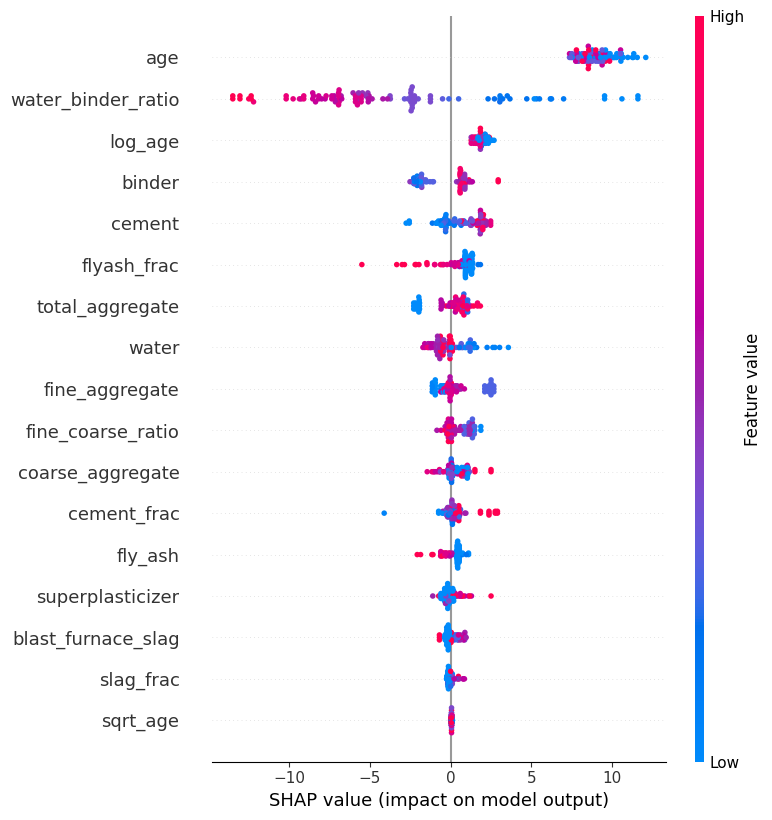

/tmp/ipython-input-4234463973.py:17: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_explain, plot_type="bar", show=True)


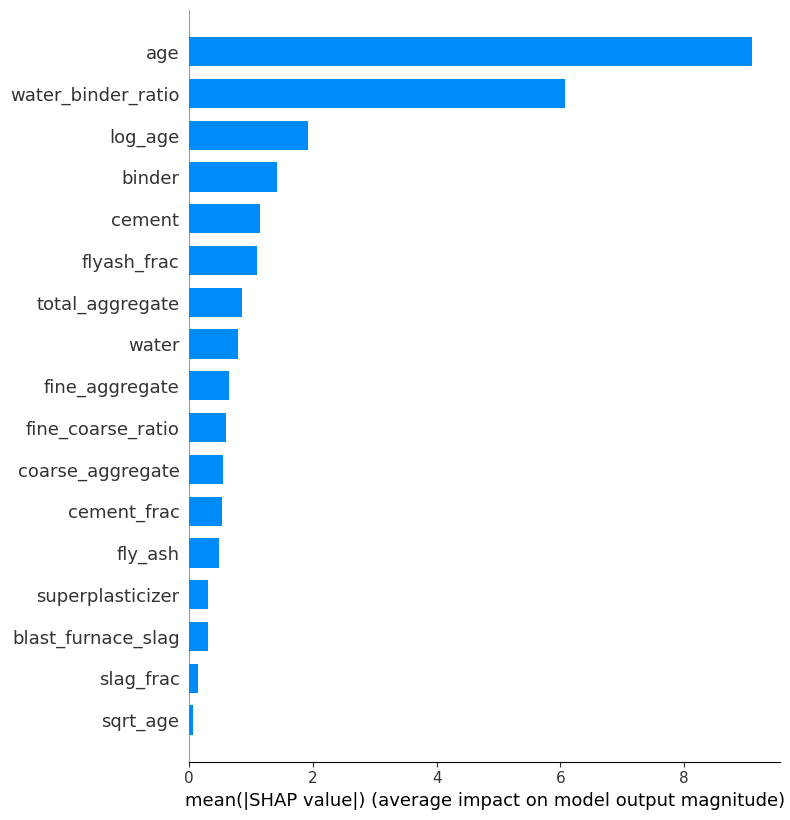

In [10]:
# Use the trained LightGBM booster
booster = lgb_model.booster_

# SHAP explainer for tree models (fast + correct for LightGBM)
explainer = shap.TreeExplainer(booster)

# IMPORTANT: Use a sample to keep it fast (you can increase sample size if needed)
X_explain = X_test.sample(min(200, len(X_test)), random_state=42)

# Compute SHAP values (how much each feature contributes to predictions)
shap_values = explainer.shap_values(X_explain)

# Global summary: which features matter most overall
shap.summary_plot(shap_values, X_explain, show=True)

# Optional: Bar chart version (clean global importance)
shap.summary_plot(shap_values, X_explain, plot_type="bar", show=True)


Predicted strength: 33.78037658409314


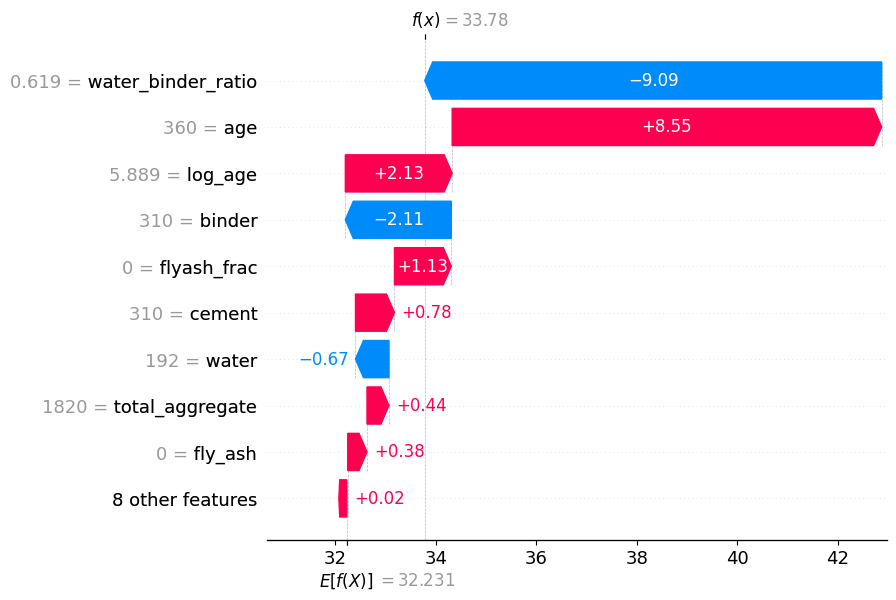

In [11]:
# Pick one test example to explain
idx = X_explain.index[0]          # change to any index you want
x_one = X_test.loc[[idx]]         # keep as DataFrame (important for SHAP)

# Prediction
pred_value = lgb_model.predict(x_one)[0]
print("Predicted strength:", pred_value)

# SHAP explanation for this single row
shap_one = explainer.shap_values(x_one)

# Waterfall plot: shows feature-by-feature contributions
shap.plots.waterfall(shap.Explanation(
    values=shap_one[0],
    base_values=explainer.expected_value,
    data=x_one.iloc[0],
    feature_names=x_one.columns
))


In [12]:
# Install LIME (run once)
!pip -q install lime

import numpy as np
import pandas as pd
from lime.lime_tabular import LimeTabularExplainer


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [13]:
# LIME needs numpy arrays + feature names
feature_names = X_train.columns.tolist()

# Create the explainer using the TRAIN data distribution
explainer = LimeTabularExplainer(
    training_data=X_train.values,         # use raw features (same as model)
    feature_names=feature_names,
    mode="regression",
    discretize_continuous=True,           # makes explanations more readable
    random_state=42
)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


LIME explanation (feature contributions):
('age > 28.00', 10.403877836668126)
('0.46 < water_binder_ratio <= 0.55', -5.198793008061882)
('binder <= 336.73', -3.0410116724503227)
('water <= 166.60', 1.9814137761482897)
('flyash_frac > 0.30', -1.6462332181607642)
('log_age > 3.37', 1.3299811091383096)
('total_aggregate > 1828.62', 1.1518827987428821)
('0.66 < cement_frac <= 0.80', 1.1374536290447703)
('6.90 < superplasticizer <= 10.10', 0.8296954197185592)
('969.00 < coarse_aggregate <= 1040.15', 0.8069443097035809)


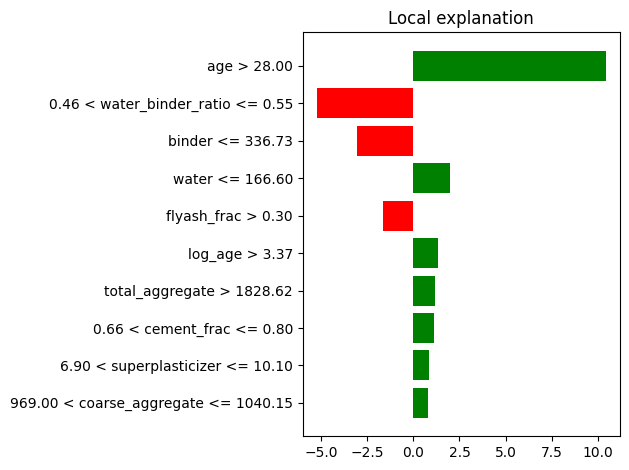

In [14]:
# Choose one sample from TEST set to explain
row_idx = 0  # change this (0, 1, 2...) to explain different samples

x_one = X_test.iloc[row_idx].values

# LIME needs a predict function that takes a 2D numpy array and returns predictions
predict_fn = lambda x: lgb_model.predict(x)

# Create explanation
exp = explainer.explain_instance(
    data_row=x_one,
    predict_fn=predict_fn,
    num_features=10   # top 10 contributing features
)

# Print explanation as text
print("LIME explanation (feature contributions):")
for item in exp.as_list():
    print(item)

# Show explanation in a notebook output (if supported)
fig = exp.as_pyplot_figure()
fig.tight_layout()


In [15]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.inspection import PartialDependenceDisplay


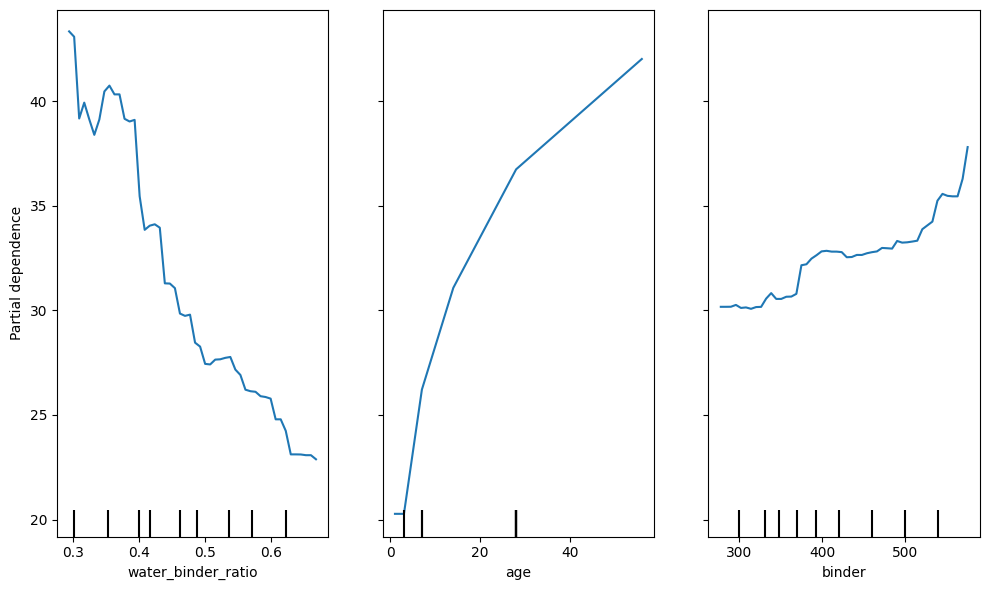

In [16]:
# Choose the top features you want to visualize
# (these are common important ones in this dataset)
features_to_plot = [
    "water_binder_ratio",
    "age",
    "binder"
]

# PDP shows the average effect of each feature on predictions
fig, ax = plt.subplots(figsize=(10, 6))
PartialDependenceDisplay.from_estimator(
    estimator=lgb_model,
    X=X_train,                         # use TRAIN distribution for stable interpretation
    features=features_to_plot,
    kind="average",                    # PDP (global average effect)
    grid_resolution=50,
    ax=ax
)
plt.tight_layout()
plt.show()


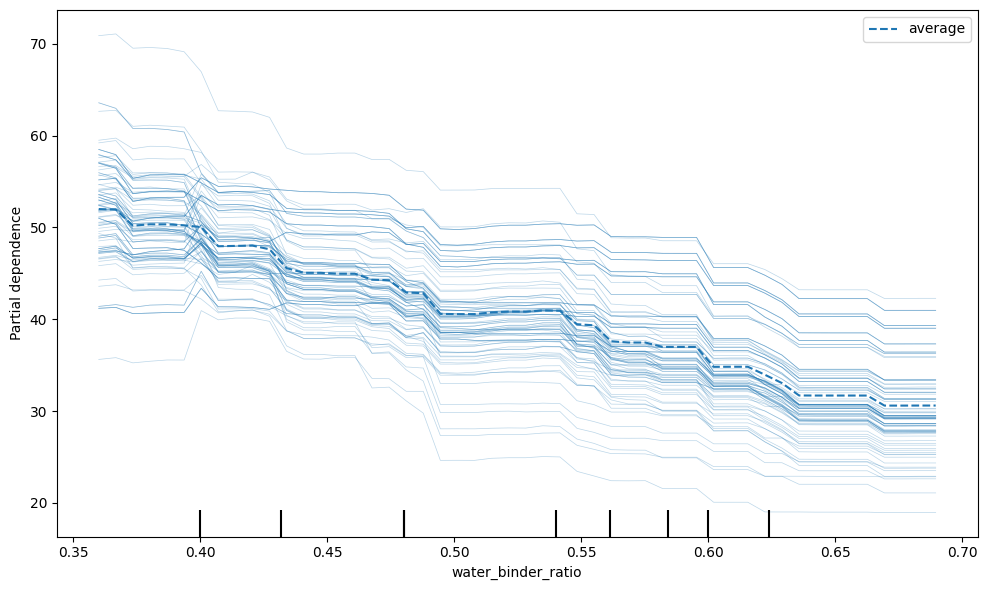

In [17]:
# ICE shows how predictions change for individual rows (many thin lines).
# This reveals if the effect varies across different samples.

feature_for_ice = "water_binder_ratio"

fig, ax = plt.subplots(figsize=(10, 6))
PartialDependenceDisplay.from_estimator(
    estimator=lgb_model,
    X=X_test.sample(min(200, len(X_test)), random_state=42),  # sample to keep plot readable
    features=[feature_for_ice],
    kind="both",                       # both PDP (average) + ICE (individual)
    grid_resolution=50,
    ax=ax
)
plt.tight_layout()
plt.show()
